In [2]:
import pandas as pd
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df


def get_human_dataset():
    
    #각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/human_activity/features.txt',sep='\s+',header=None,names=['column_index','column_name'])
    
    # 중복된 feature 명을 수정하는 get_new_feature_name_df()를 이용, 신규 feature name에 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    #DataFrame에 feature name을 column으로 부여하기 위해 list object로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    #학습 feature dataset과 test feature data를 DataFrame으로 loading, column name은 feature_name 적용
    X_train = pd.read_csv('./data/human_activity/train/X_train.txt',sep='\s+', names = feature_name)
    X_test = pd.read_csv('./data/human_Activity/test/X_test.txt',sep='\s+', names = feature_name)
    
    #학습 label과 test label를 DataFrame으로 loading하고 column name은 action으로 부여
    y_train = pd.read_csv('./data/human_activity/train/y_train.txt',sep='\s+',header=None, names = ['action'])
    y_test = pd.read_csv('./data/human_activity/test/y_test.txt',sep='\s+', header = None , names = ['action'])
    
    #load된 학습/test 용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [3]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
#개별  모델은 logistic regression과 KNN임
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

#개별 model을 soft voting 기반의 ensemble model로 구현한 classifier
vo_clf = VotingClassifier ( estimators = [('LR',lr_clf),('KNN',knn_clf)],voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,test_size=0.2, random_state= 156)

#Voting classifier 학습/예측/평가

vo_clf.fit(X_train,y_train)
pred=vo_clf.predict(X_test)
print(accuracy_score(y_test,pred))

##개별 모델의 학습/예측 평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    pred= classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print(class_name,accuracy_score(y_test,pred))

0.9473684210526315
LogisticRegression 0.9385964912280702
KNeighborsClassifier 0.9385964912280702


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#DecisionTree에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# Random forest 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred=rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print(accuracy)

0.9253478113335596


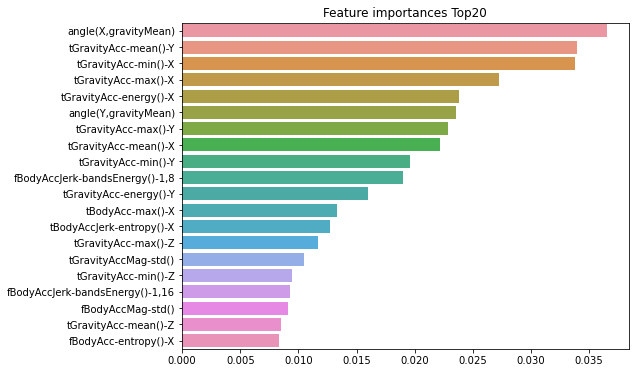

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances=pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20, y = ftr_top20.index)
plt.show()

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

#GBM 수행 시간 측정을 위함. 시작시간설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred=gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test,gb_pred)

print(gb_accuracy)
print(time.time()-start_time)

0.9389209365456397
701.2910921573639


In [12]:
import xgboost

In [13]:
print(xgboost.__version__)

1.3.3


In [14]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [16]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [17]:
## data 분할
X_train, X_test, y_train, y_test = train_test_split(X_features,y_label,test_size=0.2,random_state=156)
print(X_train.shape,X_test.shape)

(455, 30) (114, 30)


In [19]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [21]:
params = {'max_depth': 3, 'eta': 0.1, 'objective':'binary:logistic','eval_metric':'logloss','early_stoppings':100}
num_rounds = 400

In [22]:
#train dataset는 'train', evaluation(test) data set은 'eval'로 표시
wlist=[(dtrain,'train'),(dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds, early_stopping_rounds=100, evals=wlist)

[17:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0

[162]	train-logloss:0.00724	eval-logloss:0.08776
[163]	train-logloss:0.00722	eval-logloss:0.08778
[164]	train-logloss:0.00720	eval-logloss:0.08778
[165]	train-logloss:0.00718	eval-logloss:0.08752
[166]	train-logloss:0.00716	eval-logloss:0.08754
[167]	train-logloss:0.00714	eval-logloss:0.08764
[168]	train-logloss:0.00712	eval-logloss:0.08739
[169]	train-logloss:0.00710	eval-logloss:0.08738
[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08696
[177]	train-logloss:0.00696	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:

In [23]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3))

preds = [1 if x>0.5 else 0 for x in pred_probs]
print(preds[:10])

[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix,precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
def get_clf_eval(y_test, pred=None,pred_proba=None):
    confusion=confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test,pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    print(f'오차행렬은 {confusion}')
    print(f'정확도는 {accuracy}')
    print(f'정밀도는 {precision}')
    print(f'재현율은 {recall}')
    f1=f1_score(y_test,pred)
    print(f'f1 score는{f1}')
    roc_auc = roc_auc_score(y_test,pred_proba)
    print(f'roc auc score는 {roc_auc}')

In [30]:
get_clf_eval(y_test,preds,pred_probs)

오차행렬은 [[35  2]
 [ 1 76]]
정확도는 0.9736842105263158
정밀도는 0.9743589743589743
재현율은 0.987012987012987
f1 score는0.9806451612903225
roc auc score는 0.995085995085995


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

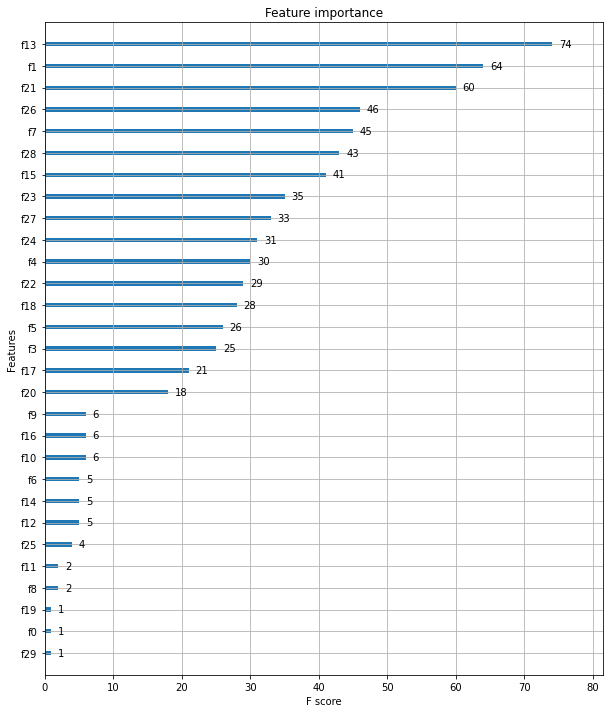

In [31]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

In [32]:
import graphviz

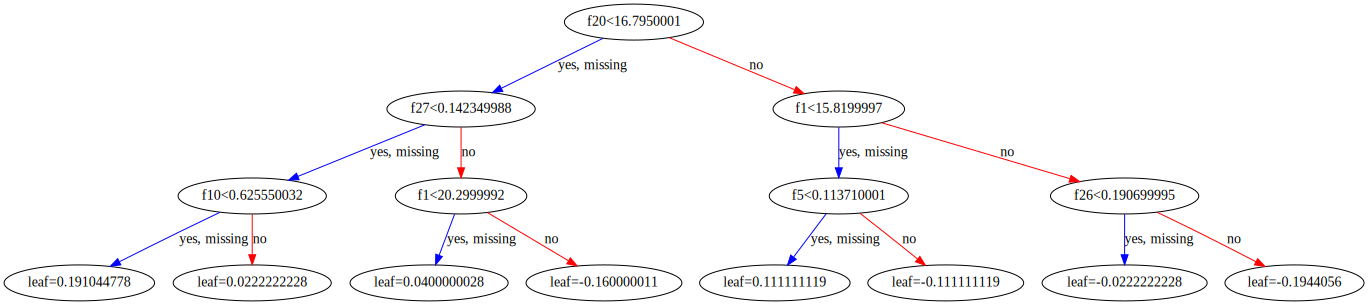

In [33]:
xgboost.to_graphviz(xgb_model)

In [34]:
from lightgbm import LGBMClassifier

In [35]:
LGBMClassifier.__version__

AttributeError: type object 'LGBMClassifier' has no attribute '__version__'

In [36]:
import pandas as pd
import numpy as np

In [37]:
dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

In [38]:
X_train, X_test, y_train, y_test = train_test_split(ftr,target,test_size=0.2,random_state=156)

#앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

#LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train,y_train, early_stopping_rounds = 100, eval_metric='logloss',eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

In [40]:
get_clf_eval(y_test,preds,pred_proba)

오차행렬은 [[33  4]
 [ 1 76]]
정확도는 0.956140350877193
정밀도는 0.95
재현율은 0.987012987012987
f1 score는0.9681528662420381
roc auc score는 0.9905229905229904


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

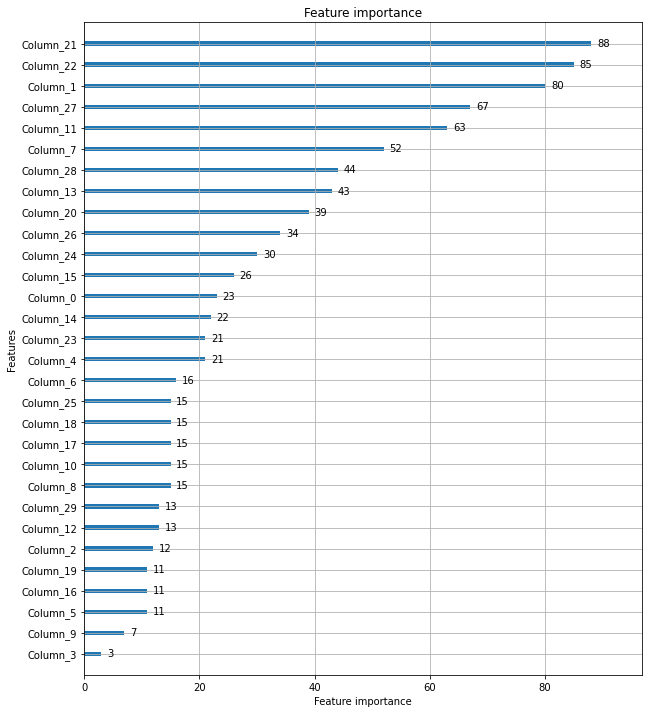

In [41]:
#plot_importance()를 이용해 feature importance 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)